In [1]:
import numpy as np
from sklearn.manifold import TSNE
import torch
from transformers import BertConfig, BertModel, BertTokenizer
from transformers import BertForMaskedLM, BertTokenizerFast, pipeline
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

In [2]:
model_id = "/share/home/pwmat/Huggingface_Model_Downloades/MatBERT_model/matbert-base-cased"
model = BertForMaskedLM.from_pretrained(model_id)
tokenizer = BertTokenizerFast.from_pretrained(model_id, do_lower_case=False)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
# 提取所有词向量
all_word_embeddings = []
all_words = []
for word in tokenizer.vocab.keys():
    if word.isalnum():  # 只选择字母数字组合的词，排除特殊标记
        token_id = tokenizer.encode(word, add_special_tokens=False)
        if len(token_id) == 1:  # 确保词没有分词成多个子词
            token_id = torch.tensor(token_id).unsqueeze(0)
            embeddings = model.bert.embeddings.word_embeddings(token_id)
            all_word_embeddings.append(embeddings.squeeze().detach().numpy())
            all_words.append(word)

all_word_embeddings = np.array(all_word_embeddings)

In [4]:
%%time
from umap import UMAP
# 使用UMAP进行降维
reducer = UMAP()
embeddings_umap = reducer.fit_transform(all_word_embeddings)

CPU times: user 2min 32s, sys: 6.47 s, total: 2min 38s
Wall time: 24 s


In [7]:
# 对UMAP降维后的二维词汇进行聚类效果排名，以"perovskite"为例
target_word = 'perovskite'
target_idx = all_words.index(target_word)
target_embedding = embeddings_umap[target_idx]
    
# 计算所有词汇与目标词汇之间的欧氏距离
distances = cdist([target_embedding], embeddings_umap, metric='euclidean').flatten()
    
# 对距离进行排序，获取最近的词汇索引（按升序排序）
sorted_indices = np.argsort(distances)
    
# 输出聚类效果排名前10的词汇及其距离
print(f"Top 10 words closest to '{target_word}' after UMAP dimensionality reduction:")
for i in range(1, 11):  # 跳过自身（距离为0）
    word_idx = sorted_indices[i]
    print(f"{i}. {all_words[word_idx]} (Distance: {distances[word_idx]:.4f})")

Top 10 words closest to 'perovskite' after UMAP dimensionality reduction:
1. rutile (Distance: 0.0213)
2. anatase (Distance: 0.0373)
3. neon (Distance: 0.0376)
4. fluorite (Distance: 0.0516)
5. pyrochlore (Distance: 0.0559)
6. xenon (Distance: 0.0573)
7. spinel (Distance: 0.0668)
8. PMN (Distance: 0.0740)
9. NBT (Distance: 0.0741)
10. zircon (Distance: 0.0746)


1. rutile (Distance: 0.0213)
2. anatase (Distance: 0.0373)
3. neon (Distance: 0.0376)
4. fluorite (Distance: 0.0516)
5. pyrochlore (Distance: 0.0559)
6. xenon (Distance: 0.0573)
7. spinel (Distance: 0.0668)
8. PMN (Distance: 0.0740)
9. NBT (Distance: 0.0741)
10. zircon (Distance: 0.0746)


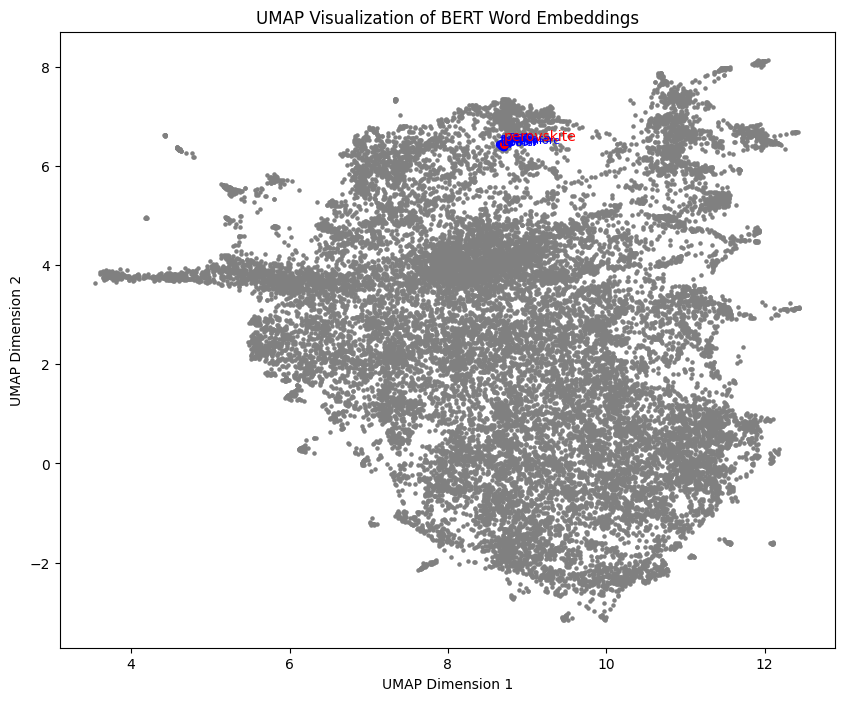

CPU times: user 365 ms, sys: 13.7 ms, total: 379 ms
Wall time: 354 ms


In [10]:
%%time
closest_words = []
for i in range(1, 11):  # 跳过自身（距离为0）
    word_idx = sorted_indices[i]
    closest_words.append(all_words[word_idx])
    print(f"{i}. {all_words[word_idx]} (Distance: {distances[word_idx]:.4f})")

# 绘制图像，标记排名前10的词汇
highlighted_words = closest_words

# 将所有坐标转换为单个数组
x_coords = embeddings_umap[:, 0]
y_coords = embeddings_umap[:, 1]

# 批量绘制所有点
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, color='gray', s=5)

# 标记高亮词汇
for word in highlighted_words:
    idx = all_words.index(word)
    plt.scatter(embeddings_umap[idx, 0], embeddings_umap[idx, 1], color='blue', s=20)
    plt.text(embeddings_umap[idx, 0], embeddings_umap[idx, 1], word, fontsize=8, ha='left', va='bottom', color='blue')

# 标记目标词汇
target_idx = all_words.index(target_word)
plt.scatter(embeddings_umap[target_idx, 0], embeddings_umap[target_idx, 1], color='red', s=30)
plt.text(embeddings_umap[target_idx, 0], embeddings_umap[target_idx, 1], target_word, fontsize=10, ha='left', va='bottom', color='red')

plt.title('UMAP Visualization of BERT Word Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.savefig('allword_highlight.png')
plt.show()

In [11]:
# 保存前1000名的词汇到sum列表
sum_words = [all_words[sorted_indices[i]] for i in range(1, 1001)]

In [13]:
print(sum_words)

['rutile', 'anatase', 'neon', 'fluorite', 'pyrochlore', 'xenon', 'spinel', 'PMN', 'NBT', 'zircon', 'ferritin', 'ilmenite', 'magnetite', 'perovskites', 'KNN', 'MgB2', 'garnet', 'FTO', 'hematite', 'titania', 'lime', 'ferrites', 'goethite', 'ferrite', 'titanate', 'BaTiO3', 'rust', 'MAPbI3', 'ITO', 'EMD', 'BDD', 'PZT', 'SRO', 'BST', 'BFO', 'CH3NH3PbI3', 'pyrite', 'LCO', 'silica', 'SrTiO3', 'manganites', 'BTO', 'olivine', 'LiNbO3', 'Silica', 'wurtzite', 'SPIO', 'TiO2', 'brass', 'quartz', 'LFP', 'Xe', 'LSCF', 'LAO', 'helium', 'Mo2C', 'LSM', 'relaxor', 'boron', 'poled', 'Fe3O4', 'TCO', 'CaF2', 'diamond', 'Si3', 'AZO', 'BiFeO3', 'cuprates', 'YBCO', 'Silicon', 'ferroelectric', 'SiOx', 'PbI2', 'WO3', 'sapphire', 'arsenic', 'chalcopyrite', 'LSMO', 'SiO2', 'magne', 'FeOOH', 'Bi2Se3', 'He', 'YAG', 'Si2', 'TiOx', 'Helium', 'CeO2', 'Bi2Te3', 'C3N4', 'STO', 'deuterium', 'Al2O3', 'Si3N4', 'B4C', 'SiN', 'tellurium', 'poling', 'TiC', 'SiO', 'LMO', 'Ar', 'CaCO3', 'selenium', 'SDC', 'd33', 'MoS2', 'ZrO2', 

#### ChatGPT提取出的化学式（欧氏距离排名前500) {perovskite}  
['PMN', 'NBT', 'KNN', 'MgB2', 'FTO', 'BaTiO3', 'MAPbI3', 'ITO', 'EMD', 'BDD', 'PZT', 'SRO', 'BST', 'BFO', 'CH3NH3PbI3', 'LCO', 
'SrTiO3', 'BTO', 'LiNbO3', 'SPIO', 'TiO2', 'LFP', 'Xe', 'LSCF', 'LAO', 'Mo2C', 'LSM', 'Fe3O4', 'TCO', 'CaF2', 'Si3', 'AZO', 
'BiFeO3', 'YBCO', 'SiOx', 'PbI2', 'WO3', 'LSMO', 'SiO2', 'FeOOH', 'Bi2Se3', 'He', 'YAG', 'Si2', 'TiOx', 'CeO2', 'Bi2Te3', 'C3N4', 
'STO', 'Al2O3', 'Si3N4', 'B4C', 'SiN', 'TiC', 'SiO', 'LMO', 'Ar', 'CaCO3', 'SDC', 'MoS2', 'ZrO2', 'MoSe2', 'CH3NH3', 'KMnO4', 'ZrB2', 
'MoO2', 'GDC', 'CaO', 'WS2', 'SiNx', '3He', 'LTO', 'BiVO4', 'BiOCl', 'HfO2', 'SiC', 'Bi2WO6', 'SnO2', 'CIGS', '4He', 'TiO', 'MoO3', 'PbTe', 'NaYF4', 'Ta2O5', 'TiB2', 'In2O3', 'YSZ', 'Bi2S3', 'GeO2', 'CoFe2O4', 'Nb2O5', 'MgO', 'PbSe', 'Bi2O3', 'BiOI', 'SrO', 
'PbO2', 'BiO', 'Mo6', 'Gd2O3', 'PbO', 'CrN', 'TiN', 'Mn3O4', 'MnO2', '40Ar', 'AZ91', 'ZnFe2O4', 'GaN', 'ZnTe', 'UO2', 'SiH', 'BaO', 
'AlN', 'Fe2O3', 'Y2O3', 'CdSe', 'CZTS', 'V2O5', 'SiH4', 'CuInS2', 'Ga2O3', 'ZnSe', '206Pb', 'MnOx', 'Mn2O3', 'TiAl', 'B2O3', 'Cs2', 
'MgAl2O4', 'CdTe', '7Li', 'Sb2', 'Cr2O3', 'N2', 'MnO', 'SiGe', 'La2O3', 'CdO', 'Bi2', 'InSb', 'ZnO', 'GaAs', 'CdS', 'InN', 'MgH2', 
'IrO2', 'VO2', 'InAs', 'AlGaAs', 'CaSO4', 'PO2', '29Si', 'SnS2', '27Al', 'GaSb', 'Co3O4', 'Ag3PO4', 'InGaN', 'PbS', 'InP', 'ZnS', 
'SQUID', 'GaP', 'AlGaN', 'K2O', 'Ce0', 'BF3', 'InGaAs', '119Sn', 'FeO', 'MoO4', '11B', 'CHA', 'NiTi', 'Te', 'Se', 'CuIn', '2Cl', 
'LiCoO2', 'Zr4', 'CoO', 'Ca3', '19F', 'Ti4', 'RuO2', '238U', 'SiO4', 'LiFePO4', 'Kr', '18O', 'Pb2', 'δ15N', 'Li4Ti5O12', 'SnS', 
'AgBr', 'Cu2S', 'Ti2', 'Ce4', 'Alumin', 'Li', 'Fe', 'Zn2', 'Pd2', 'Br', 'MgCl2', 'SF6', 'Os', 'NaF', 'Au', 'SBF', 'Ag2', 'Fe0', 
'Na2S', 'MnII', 'FeCl2', 'FeIII', 'Bi', 'Be', 'PdO', 'Hg', '137Cs', 'NaO', 'Ni', 'Cu2O', 'Zn0', 'Co', 'Mn3', 'CoCl2', 'δD', 
'LiFe', 'Pt2', 'Ni0', 'Co0', 'NiMo', 'Fe2', '2Fe', 'FeII', 'Oxygen', '14C', 'Al2', 'K2CO3', '99mTc', 'Hg2', 'LiMn', 'NaI', 
'Na', 'Sr', 'Cu', 'Cd', 'RuII', 'Ni2', 'Li2S', 'NiCl2', 'Ce3', 'Cl', 'LiCl', 'Re', 'N1s', '12C', 'Na2', 'PdCl2', 'KCl', 'Fe4', 
'CO3', 'LiOH', 'Cl2', 'Pt', 'Pb', 'CuCl2', 'Fe1', 'Mo', 'Y3', 'Sn', '5D0', 'CuCl', 'NO', 'Ir', 'Ne', 'Hg0', 'CuI', 'Pd', 'CuSO4', 
'BH4', 'Co2', 'Li4', 'NaCl', 'Ln', 'Li1', 'CoII', 'KH2PO4', 'H2S', 'Na2CO3', 'Rh', 'KNO3', 'C1s', 'Gd3', 'Li0', '11C', 'NiII', 
'LiTFSI', 'Nb', 'NaNO3', 'Co3', '210Pb', 'CFC', 'LiPF6', 'Ga', 'Ni3', 'Li2', 'Li3', 'LiClO4', '2SO4', 'NaH2PO4', 'Ln3', 'Cu2', 
'Na2HPO4', 'Nd', 'KOH', 'Sb', 'Ru', 'Bq', 'Cu6', 'SO4', 'AISI', 'Cu4', 'Lix', 'Sc', 'Eu3', 'Eu2', 'H2O2', 'Ag3', 'Cu3', 'Cu1', 
'NaOH', 'Br2', 'SO2', 'Na2SO4', 'Tb3', 'BuLi', 'NOx', 'Cu0', 'Pr', 'CuII', 'Pr3', 'NaHCO3', 'Nd3', 'Yb3', 'NH4Cl', 'Er3', 'Ho3', 
'O1s', 'CH4', '1O2', 'NO2', 'Gd', 'Sm3', 'Dy3', 'Tm3', 'NaClO4', 'CF4', 'Yb', 'SO3', 'N2O', 'HBr', 'NH4OH', 'NCS', 'C28', '316L', 
'SCN', 'PC71BM', 'CH', 'C57', 'HO', 'H3PO4', 'Er', 'C31', 'HFC', 'PFC', 'OH', 'C29', 'C44', 'HNO3', 'C33', 'C32', 'NO3', 'Tb', 
'C18', 'PCBM', 'NH3', 'C30', 'HCl', 'TEOS', 'Brom', 'H2PO4', 'NH4', 'C26', 'Cyp', 'C70', 'C25', 'C27', 'P21', 'C60', 'H2SO4', 
'C14', 'C13', 'Acid', 'pH', 'ArC', 'C15', 'C16', 'C20', 'Cs', 'C21']


In [15]:
# 对UMAP降维后的二维词汇进行聚类效果排名，以"photovoltaic"为例
target_word = 'photovoltaic'
target_idx = all_words.index(target_word)
target_embedding = embeddings_umap[target_idx]
    
# 计算所有词汇与目标词汇之间的欧氏距离
distances = cdist([target_embedding], embeddings_umap, metric='euclidean').flatten()
    
# 对距离进行排序，获取最近的词汇索引（按升序排序）
sorted_indices = np.argsort(distances)
    
# 输出聚类效果排名前10的词汇及其距离
print(f"Top 10 words closest to '{target_word}' after UMAP dimensionality reduction:")
for i in range(1, 11):  # 跳过自身（距离为0）
    word_idx = sorted_indices[i]
    print(f"{i}. {all_words[word_idx]} (Distance: {distances[word_idx]:.4f})")


Top 10 words closest to 'photovoltaic' after UMAP dimensionality reduction:
1. ECL (Distance: 0.0063)
2. phosphorescent (Distance: 0.0168)
3. fluorescent (Distance: 0.0179)
4. chemiluminescence (Distance: 0.0196)
5. DSSCs (Distance: 0.0217)
6. DSSC (Distance: 0.0236)
7. fluorescence (Distance: 0.0252)
8. OCV (Distance: 0.0275)
9. EQE (Distance: 0.0279)
10. Voc (Distance: 0.0284)


In [17]:
# 保存前1000名的词汇到sum列表
sum_words = [all_words[sorted_indices[i]] for i in range(1, 1001)]

In [18]:
print(sum_words)

['ECL', 'phosphorescent', 'fluorescent', 'chemiluminescence', 'DSSCs', 'DSSC', 'fluorescence', 'OCV', 'EQE', 'Voc', 'phosphorescence', 'DSCs', 'luminescent', 'luminescence', 'photoluminescence', 'lumin', 'Jsc', 'emissive', 'SOFCs', 'emits', 'MFCs', 'oc', 'phosphor', 'emitters', 'emitter', 'DMFC', 'emissions', 'JSC', 'photovoltaics', 'electroluminescence', 'Photoluminescence', 'emit', 'phosphors', 'photoconductivity', 'photoconduc', 'emitted', 'Emission', 'submicron', 'Fluorescence', 'Solar', 'SOFC', 'fluoresc', 'IPCE', 'photocurrent', 'sun', 'supercapacitors', 'PSCs', 'sunlight', 'photoelectric', 'scintill', 'photoiniti', 'PEC', 'supercapacitor', 'battery', 'daylight', 'pseudocapac', 'αh', 'luminous', 'solar', 'OLEDs', 'sensi', 'LIF', 'sensitization', 'sensitizers', 'emission', 'sensitiz', 'OLED', 'sensitizer', 'photovoltage', 'emitting', 'radiative', 'photosensitizer', 'LIBs', 'batteries', 'sensitized', 'Hamamatsu', 'photost', 'photoproduc', 'photoin', 'photosensitiz', 'photobleaching

#### ChatGPT提取出的化学式（欧氏距离排名前500) {photovaltaic}  
['DSSCs', 'DSSC', 'DSCs', 'SOFCs', 'MFCs', 'DMFC', 'PSCs', 'OLEDs', 'LIBs', 'SOFC', 'OPV', 'OLED', 'LIBs', 'PEMFC', 'PV', 
'P25', 'OLEDs', 'LEDs', 'OLED', 'SOFC', 'TFTs', 'LIBs', 'LED', 'OLED', 'OLED', 'PMT', 'LED', 'LIBs', 'OPV', 'PV', 'PEC', 
'PECVD', 'LIBs', 'LED', 'OLEDs', 'LiCoO2', 'LiNbO3', 'Li4Ti5O12', 'LiClO4', 'Li', 'Ni', 'SnS2', 'TiO2', 'MoSe2', 'SiH4', 
'CdSe', 'Na2HPO4', 'Bi2Te3', 'SnS', 'SnS2', 'Bi2Se3', 'PCBM', 'PC71BM', 'Si', 'GaSb', 'PbSe', 'PbTe', 'CuInS2', 'CuInSe2', 
'CIGS', 'MAPbI3', 'CH3NH3PbI3', 'Bi2S3', 'Bi2WO6', 'BiVO4', 'Bi2Te3', 'Bi2Se3', 'Al2O3', 'ZnO', 'CuO', 'TiO2', 'CuInSe2', 
'CdTe', 'ZnS', 'CuO', 'ZnO', 'SnO2', 'TiO2', 'LiCoO2', 'Na2Ti3O7', 'SnO2', 'MnO2', 'TiO2', 'Al2O3', 'SnS', 'LiCoO2', 'P25', 
'Y2O3', 'ZnO', 'Al2O3', 'Li4Ti5O12', 'MoSe2', 'PbI2', 'Sb2S3', 'CdSe', 'SnO2', 'Na2Ti3O7', 'CuInS2', 'CuInSe2', 'Bi2Te3', 
'Al2O3', 'PbSe', 'SiO2', 'PbTe', 'TiO2', 'ZnS', 'CuO', 'CuInS2', 'ZnO', 'PbSe', 'MoSe2', 'PbS', 'PbSe', 'SiH4', 'SnS', 
'Na2HPO4', 'SiO2', 'TiO2', 'PbI2', 'Sb2', 'PbTe', 'CuO', 'SnO2', 'ZnO', 'TiO2', 'CuInSe2', 'CdTe', 'PbSe', 'CuInS2', 
'Na2HPO4', 'ZnO', 'CuInSe2', 'ZnO', 'MoSe2', 'Bi2Te3', 'PbTe', 'TiO2', 'PbSe', 'MoSe2', 'CdSe', 'CuO', 'PbS', 'PbSe', 
'PbI2', 'SnO2', 'SiO2', 'CuInSe2', 'LiCoO2', 'CuInS2', 'PbSe', 'SnO2', 'PbI2', 'SiO2', 'PbSe', 'ZnO', 'TiO2', 'TiO2', 
'PbTe', 'ZnO', 'SnO2', 'SnS2', 'CuO', 'CuInS2', 'SnS', 'SnS2', 'Si', 'PbS']
